In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import json

with open("howpop_train.jsonlines") as file:
    records = [json.loads(line) for line in file]
    df = pd.DataFrame(records)

In [7]:
import json

with open("howpop_test.jsonlines") as file:
    records = [json.loads(line) for line in file]
    test = pd.DataFrame(records)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134137 entries, 0 to 134136
Data columns (total 18 columns):
_id           134137 non-null object
_spider       134137 non-null object
_timestamp    134137 non-null float64
author        134137 non-null object
content       134137 non-null object
domain        134137 non-null object
flags         134137 non-null object
flow          97048 non-null object
hubs          134137 non-null object
link_tags     134137 non-null object
meta_tags     134137 non-null object
polling       4725 non-null object
post_id       134137 non-null int64
published     134137 non-null object
quality       134137 non-null object
tags          134137 non-null object
title         134137 non-null object
url           134137 non-null object
dtypes: float64(1), int64(1), object(16)
memory usage: 18.4+ MB


In [9]:
df = df.drop(["_id", "_spider", "_timestamp", "author", "polling", "post_id", "url", "link_tags"], axis=1)

In [10]:
test = test.drop(["_id", "_spider", "_timestamp", "author", "polling", "post_id", "url", "link_tags"], axis=1)

In [11]:
def favs_lognorm(df):
    favs_lognorm = []
    for i in range(len(df)):
        favs_lognorm.append(df['quality'][i]['favs_lognorm'])
    df['favs_lognorm'] = favs_lognorm

In [12]:
favs_lognorm(df)
favs_lognorm(test)

In [13]:
df = df.drop("quality", axis=1)
test = test.drop("quality", axis=1)

In [ ]:
from datetime import datetime

def published(df):
    df['published'] = df['published'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

    year = []
    month = []
    day = []

    for i in range(len(df)):
        year.append(df['published'][i].year)
        month.append(df['published'][i].month)
        day.append(df['published'][i].day)
    df['year'] = year
    df['month'] = month
    df['day'] = day

In [ ]:
published(df)
published(test)

In [14]:
df = df.drop("published", axis=1)
test = test.drop("published", axis=1)

In [ ]:
description(df)
description(test)

In [15]:
df = df.drop("meta_tags", axis=1)
test = test.drop("meta_tags", axis=1)

In [16]:
df = pd.get_dummies(df, columns=["domain", "flow"])
test = pd.get_dummies(test, columns=["domain", "flow"])

In [17]:
def enc_flags(df):
    flags = {}
    for i in range(len(df)):
        #f = json.loads(df['flags'].iloc[i].replace("'", '\"'))
        f = df['flags'].iloc[i]
        for flag in f:
            if flag not in flags:
                flags[flag] = [0] * len(df)
            flags[flag][i] = 1

    for flag in flags:
        df['flag_' + flag] = flags[flag]

In [18]:
enc_flags(df)
enc_flags(test)

In [19]:
df = df.drop("flags", axis=1)
test = test.drop("flags", axis=1)

In [20]:
def hubs(df):
    hubs = {}
    for i in range(len(df)):
        for j in range(len(df['hubs'].iloc[i])):
            if df['hubs'].iloc[i][j]['title'] not in hubs:
                hubs[df['hubs'].iloc[i][j]['title']] = [0] * len(df)
            hubs[df['hubs'].iloc[i][j]['title']][i] = 1
    for hub in hubs:
        df[hub] = hubs[hub]

In [21]:
hubs(df)
hubs(test)

In [22]:
train = df.drop(['content', 'hubs', 'tags', 'title'], axis=1)
test = test.drop(['content', 'hubs', 'tags', 'title'], axis=1)

In [23]:
train = train[67068:]

In [24]:
train_target = train["favs_lognorm"]
train = train.drop("favs_lognorm", axis=1)
test_target = test["favs_lognorm"]
test = test.drop("favs_lognorm", axis=1)

In [25]:
def equal_columns(train, test):
    for c in train.columns:
        if c not in test.columns:
            test[c] = [0] * len(test)
    for c in test.columns:
        if c not in train.columns:
            train[c] = [0] * len(train)

In [26]:
equal_columns(train, test)

In [41]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

bestA = 0
bestMSE = 1000
errors = []
for a in range(100, 120):
    clf = Ridge(alpha=a)
    clf.fit(train, train_target)
    prediction = clf.predict(test)
    MSE = mean_squared_error(test_target, prediction)
    errors.append(MSE)
    if MSE < bestMSE:
        bestMSE = MSE
        bestA = a

In [42]:
print(bestA, bestMSE)

119 1.10280468208


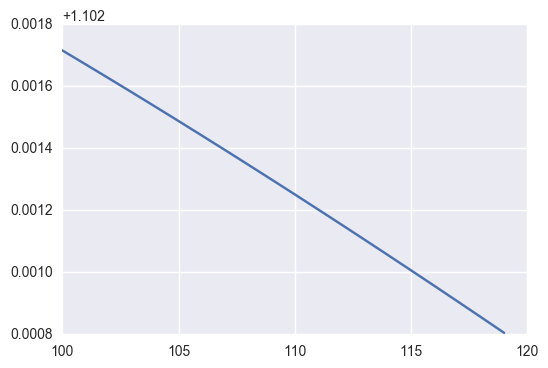

In [44]:
plt.plot([a for a in range(100, 120)], errors)
plt.show()